# Projet P6 : Classifiez automatiquement des biens de consommation

## Contexte

<b> MISSION 1 : </b>

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.

Linda, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification d’articles, en utilisant leur image et leur description sur le jeu de données d'articles disponible dans la première pièce jointe de ce mail.

Pourrais-tu analyser les descriptions textuelles et les images des produits, au travers des étapes suivantes : 
- Un prétraitement des données texte et image 
- Une extraction de features 
- Une réduction en 2 dimensions, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle 
- Une analyse du graphique afin de conclure, à l’aide des descriptions ou des images, sur la faisabilité de regrouper automatiquement des produits de même catégorie 
- Une réalisation d’une mesure pour confirmer ton analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters
 
Pourrais-tu nous démontrer ainsi la faisabilité de regrouper automatiquement des produits de même catégorie ? 

Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
- un algorithme de type SIFT / ORB / SURF ;
- un algorithme de type CNN Transfer Learning.
 
Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : 
- deux approches de type bag-of-words, comptage simple de mots et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder).

<b> MISSION 2 : </b>

Pourrais-tu réaliser une classification supervisée à partir des images ? Je souhaiterais que tu mettes en place une data augmentation afin d’optimiser le modèle.

De plus, nous souhaitons élargir notre gamme de produits à l’épicerie fine. 
Pour cela, pourrais-tu tester la collecte de produits à base de “champagne” via l’API disponible  ici ?
https://developer.edamam.com/food-database-api

Pourrais-tu ensuite nous proposer un script ou notebook Python permettant une extraction des 10 premiers produits dans un fichier “.csv”, contenant pour chaque produit les données suivantes : foodId, label, category, foodContentsLabel, image.

## Etapes du projet :

Démontrer la faisabilité de regrouper automatiquement des produits de même catégorie.

- <b> Etape préliminaire : </b> Importation des données ( --> NoteBook1 : Traitement des textes )
- <b> Etape 1 : </b> Text cleaning et feature engineering ( --> NoteBook1 : Traitement des textes ) 
- <b> Etape 2 : </b> Catégorisation des descriptions ( --> NoteBook 2 et 3 : Méthodes bag of words et Word_embedding )
- <b> Etape 3 : </b> Pré-traitement et classification d'images (SIFT et CNN) ( --> NoteBook4 : Traitement des images )
- <b> Etape 4 : </b> Classification supervisée des images ( --> NoteBook5 : Classification des images )
- <b> Etape 5 : </b> Collecte de produits via API ( --> NoteBook6 : Collecte produits API )

### Environnement de travail et librairies

In [16]:
import sys
# Mon environnement virtuel :
print(sys.executable)
# La version de Python dans mon environnement virtuel :
print(sys.version)

C:\Users\druar\anaconda3\envs\Formation_P6_PARTIE2\python.exe
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]


In [63]:
# Builtin
import os
# Définir le nombre de cœurs que vous souhaitez utiliser
os.environ['LOKY_MAX_CPU_COUNT'] = '14'

# Data
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Viz
import matplotlib.pyplot as plt

# NLTK 
import string

# NLP - tensorflow
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim # Nécessite la relance de pip install scipy 10.0.0 car dans la version 10.4 de scipy, la fonction triu n'est plus présente 

from keras.models import Model # Classe pour créer un modèle en utilisant l'API fonctionnelle de Keras
from keras.layers import Input, Embedding, GlobalAveragePooling1D
# Input = Classe pour définir les couches d'entrée du modèle
# Embedding = Couche d'embedding pour transformer les indices de mots en vecteurs d'embedding
# GlobalAveragePooling1D = Couche pour appliquer un pooling global moyen sur les séquences d'embedding

# Bert
import transformers
from transformers import *
os.environ["TF_KERAS"]='1'

# Clustering
from sklearn import cluster, metrics

# Reduction dimension
from sklearn import manifold, decomposition

### Importation des données d'origine

In [21]:
articles_text_BERT = pd.read_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\articles_text_BERT.csv")
articles_text_BERT.head()

,description,category_product
0,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


### Importation des données cleanées

In [24]:
articles_text_clean = pd.read_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\articles_text_clean.csv")
articles_text_clean.head()

,tokens,description,category_product
0,"['key', 'feature', 'elegance', 'polyester', 'm...",key feature elegance polyester multicolor abst...,Home Furnishing
1,"['specification', 'cotton', 'bath', 'towel', '...",specification cotton bath towel bath towel red...,Baby Care
2,"['key', 'feature', 'eurospa', 'cotton', 'terry...",key feature eurospa cotton terry face towel se...,Baby Care
3,"['key', 'feature', 'santosh', 'royal', 'fashio...",key feature santosh royal fashion cotton print...,Home Furnishing
4,"['key', 'feature', 'jaipur', 'print', 'cotton'...",key feature jaipur print cotton floral king si...,Home Furnishing


In [26]:
# Convertir les chaînes en listes de tokens
import ast
articles_text_clean['tokens'] = articles_text_clean['tokens'].apply(ast.literal_eval)
articles_text_clean.head()

,tokens,description,category_product
0,"[key, feature, elegance, polyester, multicolor...",key feature elegance polyester multicolor abst...,Home Furnishing
1,"[specification, cotton, bath, towel, bath, tow...",specification cotton bath towel bath towel red...,Baby Care
2,"[key, feature, eurospa, cotton, terry, face, t...",key feature eurospa cotton terry face towel se...,Baby Care
3,"[key, feature, santosh, royal, fashion, cotton...",key feature santosh royal fashion cotton print...,Home Furnishing
4,"[key, feature, jaipur, print, cotton, floral, ...",key feature jaipur print cotton floral king si...,Home Furnishing


In [28]:
# Afficher la longueur des tokens 
df = articles_text_clean.copy()
df['token_count'] = df['tokens'].apply(len)

# Trouver le nombre maximum de tokens
max_tokens = df['token_count'].max()
print(f"Le nombre maximum de tokens dans la colonne 'tokens' est : {max_tokens}")

Le nombre maximum de tokens dans la colonne 'tokens' est : 285


## ETAPE 2 : Catégorisation des descriptions (étude de faisabilité)

ETAPE 2
    
    1. Encodage simple (méthodes Bag of words)
        1. Comptage simple (CountVectorizer)
        2. Tf_IDF
    2. Encodage complexe (algo de word embeddings)
        1. Word2Vec
        2. BERT
        3. Universal Sentence Encoder

### 1. Encodage simple avec les méthodes Bag Of Words

#### *** Fonctions communes ***

In [34]:
l_cat = list(set(articles_text_clean['category_product']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(articles_text_clean.iloc[i]['category_product'])) for i in range(len(articles_text_clean))]

catégories :  ['Baby Care', 'Watches', 'Beauty and Personal Care', 'Home Furnishing', 'Kitchen & Dining', 'Computers', 'Home Decor & Festive Needs']


In [80]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, n_iter=2000, init='random', random_state=42)
    # tsne = manifold.TSNE(n_components=2, perplexity=30, max_iter=2000, init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=10, random_state=42)
    # cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des descriptions par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des descriptions par clusters')
    
    plt.show()
    print("ARI : ", ARI)

#### 1. Méthode par comptage des tokens

#### -- CountVectorizer --

In [40]:
# Identifier les bigrammes :
# tokens = word_tokenize(articles_text_clean['description'][2])
# bigrams = ngrams(tokens,2)
# for words in bigrams:
#    print(words)
# Pour aller plus loin avec les bigrammes, la librairie Gensim permet de selectionner uniquement ceux qui apparaissent plusieurs fois

In [48]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(articles_text_clean['description'])

In [50]:
# Obtenir les noms des features (mots)
feature_names = vectorizer.get_feature_names_out()

# Convertir la matrice termes-documents en DataFrame
df_vectorized = pd.DataFrame(X.toarray(), columns=feature_names)

# Afficher le DataFrame vectorisé : df avec tous les termes uniques en colonnes et les descriptions en lignes
df_vectorized.head()

,aapno,able,absorbent,abstract,accessory,actual,adapter,adaptor,add,addition,...,would,wow,wrap,yarn,year,yellow,yes,yet,youre,youthful
0,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [52]:
# Concaténer le DataFrame original avec le DataFrame vectorisé
articles_text_encode = pd.concat([articles_text_clean, df_vectorized], axis=1)

# Afficher le DataFrame combiné
articles_text_encode.head()

,tokens,description,category_product,aapno,able,absorbent,abstract,accessory,actual,adapter,...,would,wow,wrap,yarn,year,yellow,yes,yet,youre,youthful
0,"[key, feature, elegance, polyester, multicolor...",key feature elegance polyester multicolor abst...,Home Furnishing,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[specification, cotton, bath, towel, bath, tow...",specification cotton bath towel bath towel red...,Baby Care,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,0,0
2,"[key, feature, eurospa, cotton, terry, face, t...",key feature eurospa cotton terry face towel se...,Baby Care,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,"[key, feature, santosh, royal, fashion, cotton...",key feature santosh royal fashion cotton print...,Home Furnishing,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,"[key, feature, jaipur, print, cotton, floral, ...",key feature jaipur print cotton floral king si...,Home Furnishing,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### -- Réduction de dimension (t-SNE) et clustering --

In [82]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(df_vectorized)

CountVectorizer : 
-----------------


C:\Users\druar\anaconda3\envs\Formation_P6_PARTIE2\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.4168 time :  21.0


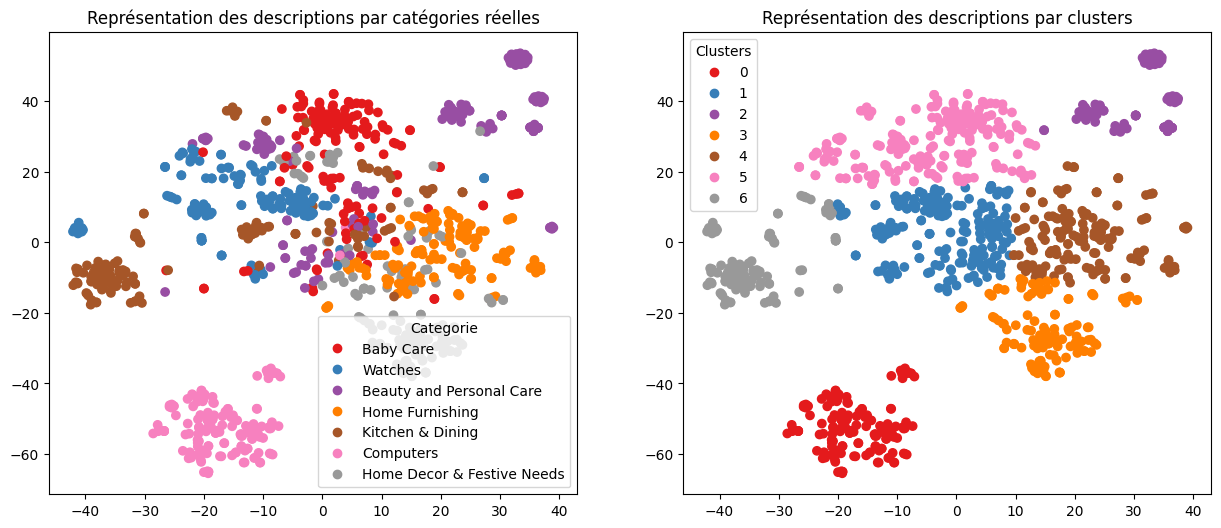

ARI :  0.4168


In [83]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

<div class="alert alert-block alert-info">
    <b> BILAN : </b> 
    
- ARI de 0.42 avec la méthode d'encodage basique de comptage des tokens.
    
</div>

#### 2. Méthode de comptage par pondération

#### -- Tf-IDF --

TFIDF (Term Frequency – Inverse Document Frequency) est une approche bag-of-words permettant de représenter les mots d’un document à l’aide d’une matrice de nombres.
TFIDF est une méthode efficace utilisée dans de nombreux outils de querying puisqu’elle donne de l’importance aux mots qui apparaissent de temps en temps mais pas trop, tout en en limitant l’importance des mots qui apparaissent souvent.

In [90]:
vect = TfidfVectorizer (ngram_range=(1,1)) # possibilité d'ajouter les bigrammes avec ngram_range=(1,2)
tfidf_mat = vect.fit_transform(articles_text_clean['description'])

In [92]:
feature_names = vect.get_feature_names_out()

In [94]:
# Convertir la matrice en DataFrame
dense = tfidf_mat.todense()

df_vectorized_tfidf = pd.DataFrame(dense.tolist(), columns=feature_names)

# Afficher le DataFrame vectorisé : df avec tous les termes uniques en colonnes et les descriptions en lignes
df_vectorized_tfidf.head()

,aapno,able,absorbent,abstract,accessory,actual,adapter,adaptor,add,addition,...,would,wow,wrap,yarn,year,yellow,yes,yet,youre,youthful
0,0.0,0.0,0.0,0.195671,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.19938,0.076860,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.042053,0.00000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.044100,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.037018,0.0,0.0,0.0


In [96]:
# Concaténer le DataFrame original avec le DataFrame vectorisé
articles_text_tfidf = pd.concat([articles_text_clean, df_vectorized_tfidf], axis=1)

# Afficher le DataFrame combiné
articles_text_tfidf.head()

,tokens,description,category_product,aapno,able,absorbent,abstract,accessory,actual,adapter,...,would,wow,wrap,yarn,year,yellow,yes,yet,youre,youthful
0,"[key, feature, elegance, polyester, multicolor...",key feature elegance polyester multicolor abst...,Home Furnishing,0.0,0.0,0.0,0.195671,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0
1,"[specification, cotton, bath, towel, bath, tow...",specification cotton bath towel bath towel red...,Baby Care,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.19938,0.076860,0.0,0.0,0.0
2,"[key, feature, eurospa, cotton, terry, face, t...",key feature eurospa cotton terry face towel se...,Baby Care,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.042053,0.00000,0.000000,0.0,0.0,0.0
3,"[key, feature, santosh, royal, fashion, cotton...",key feature santosh royal fashion cotton print...,Home Furnishing,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.044100,0.0,0.0,0.0
4,"[key, feature, jaipur, print, cotton, floral, ...",key feature jaipur print cotton floral king si...,Home Furnishing,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.037018,0.0,0.0,0.0


#### -- Réduction de dimension (t-SNE) et clustering --

In [99]:
print("Tf-IDF : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(df_vectorized_tfidf)

Tf-IDF : 
-----------------


C:\Users\druar\anaconda3\envs\Formation_P6_PARTIE2\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.4351 time :  18.0


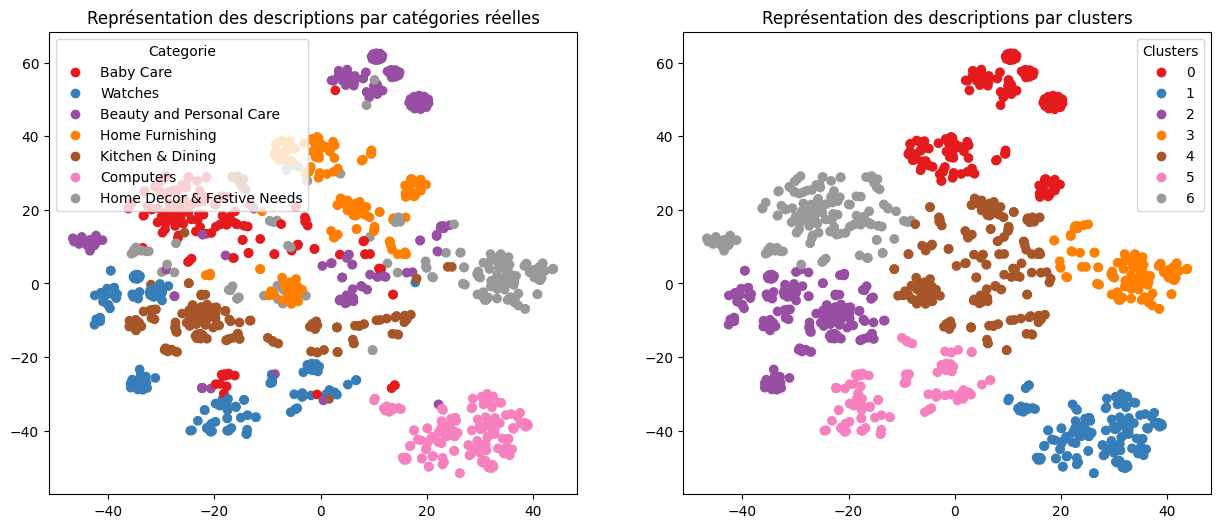

ARI :  0.4351


In [100]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

<div class="alert alert-block alert-info">
    <b> BILAN : </b> 
    
- ARI de 0.44 avec la méthode d'encodage pondéré des tokens.
    
</div>

### 2. Encodage complexe - Word Embeddings

#### *** Fonctions communes ***

In [19]:
l_cat = list(set(articles_text_clean['category_product']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(articles_text_clean.iloc[i]['category_product'])) for i in range(len(articles_text_clean))]

catégories :  ['Home Decor & Festive Needs', 'Home Furnishing', 'Computers', 'Beauty and Personal Care', 'Watches', 'Kitchen & Dining', 'Baby Care']


In [21]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, max_iter=2000, init='random', random_state=42)
    # tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=10, random_state=42)
    # cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des descriptions par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des descriptions par clusters')
    
    plt.show()
    print("ARI : ", ARI)

#### 1. Word2Vec

#### -- Création du modèle Word2Vec --

In [299]:
w2v_size=200 # taille des vecteurs de mots (300 dimensions)
w2v_window=5 # taille de la fenêtre contextuelle pour Word2Vec (5 mots de chaque côté)
w2v_min_count=1 # nombre minimum d'occurrences d'un mot pour qu'il soit inclus dans le vocabulaire
w2v_epochs=100 # nombre d'époques d'entraînement pour Word2Vec (100 époques)
maxlen = 300 # longueur maximale des phrases après padding (en tokens) --> la longueur max des phrases que j'ai : 285
sentences = articles_text_clean['description'].to_list()
# Prétraitement des phrases avec gensim.utils.simple_preprocess, ce qui inclut la conversion en minuscules, la suppression de la ponctuation, et la tokenisation.
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [301]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
# Initialisation du modèle Word2Vec avec les paramètres définis
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences) # Construction du vocabulaire à partir des phrases
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs) # Entraînement du modèle sur les phrases
model_vectors = w2v_model.wv # Extraction des vecteurs de mots entraînés
w2v_words = model_vectors.index_to_key # Liste des mots dans le vocabulaire entraîné
print("Vocabulary size: %i" % len(w2v_words)) # Affichage de la taille du vocabulaire
print("Word2Vec trained") # Indication de la fin de l'entrainement

Build & train Word2Vec model ...
Vocabulary size: 1172
Word2Vec trained


In [302]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer() # Initialisation du tokenizer
tokenizer.fit_on_texts(sentences) # Ajustement du tokenizer sur les phrases, créant un dictionnaire de mots à indices.
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
# Conversion des phrases en séquences d'indices et application du padding pour obtenir des séquences de longueur fixe (24 tokens).                                                    
num_words = len(tokenizer.word_index) + 1 # Calcul du nombre de mots uniques
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 1173


#### -- Création de la matrice d'embedding --

In [304]:
# Création de la matrice d'embedding

# 1. Initialisation des paramètres et variables
print("Create Embedding matrix ...")

word_index = tokenizer.word_index # Le dictionnaire de mots et leurs indices généré par le tokenizer.
vocab_size = len(word_index) + 1 # La taille du vocabulaire (nombre de mots uniques + 1 pour l'indexation à partir de 1).
embedding_matrix = np.zeros((vocab_size, w2v_size)) # Initialisation de la matrice d'embedding avec des zéros. Dimension de (vocab_size, w2v_size)

# 2. Remplissage de la Matrice d'Embedding
# Initialisation des compteurs pour les mots totaux (i) et les mots trouvés dans le modèle Word2Vec (j)
i=0
j=0
    
for word, idx in word_index.items(): # Boucle sur chaque mot et son index dans le dictionnaire word_index
    i +=1 # Incrément du compteur total de mots
    if word in w2v_words: # Vérifie si le mot existe dans les vecteurs de mots entraînés
        j +=1 # Incrément du compteur de mots trouvés dans Word2Vec
        embedding_vector = model_vectors[word] # Récupère le vecteur de mots pour le mot courant
        if embedding_vector is not None: # Vérifie que le vecteur n'est pas None
            embedding_matrix[idx] = model_vectors[word] # Assigne le vecteur de mots à la position correspondante dans la matrice d'embedding

# 3. Calcul et Affichage du Taux de Couverture des Embeddings
word_rate = np.round(j/i,4) # Calcule le taux de couverture des embeddings = la proportion de mots du vocabulaire qui ont des vecteurs d'embedding disponibles dans Word2Vec
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape)) # dimensions de la matrice d'embedding

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (1173, 200)


#### -- Création du modèle d'embedding --

In [306]:
# Création du modèle : modèle de deep learning utilisant Keras, qui intègre une couche d'embedding basée sur les vecteurs Word2Vec pré-entraînés

input=Input(shape=(len(x_sentences),maxlen),dtype='float64') # Définition d'une couche d'entrée pour les séquences de mots. shape indique que la couche d'entrée accepte des données de forme (len(x_sentences), maxlen).
word_input=Input(shape=(maxlen,),dtype='float64') # Définition d'une autre couche d'entrée pour les séquences de mots, avec une longueur de séquence de maxlen.
# Création de la couche d'embedding :
word_embedding=Embedding(input_dim=vocab_size, # Taille du vocabulaire
                         output_dim=w2v_size, # Dimension des vecteurs d'embedding
                         weights = [embedding_matrix] # Poids de la couche d'embedding initialisés avec la matrice d'embedding pré-entraînée
                         )(word_input) # (word_input): Application de la couche d'embedding à word_input
word_vec=GlobalAveragePooling1D()(word_embedding) # GlobalAveragePooling1D(): Applique un pooling global moyen, ce qui calcule la moyenne des embeddings sur la dimension temporelle (séquence).
# (word_embedding): Application de la couche de pooling à la sortie de la couche d'embedding.
embed_model = Model([word_input],word_vec) # Crée un modèle Keras en utilisant l'API fonctionnelle, avec word_input comme entrée et word_vec comme sortie

embed_model.summary() # Affiche un résumé du modèle, y compris les couches, les formes des entrées et sorties, et le nombre de paramètres

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_11 (Embedding)        │ (None, 300, 200)       │       234,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_11     │ (None, 200)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,600 (916.41 KB)

 Trainable params: 234,600 (916.41 KB)

 Non-trainable params: 0 (0.00 B)

#### -- Exécution du modèle --

In [312]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


(1050, 200)

In [314]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.4427 time :  6.0


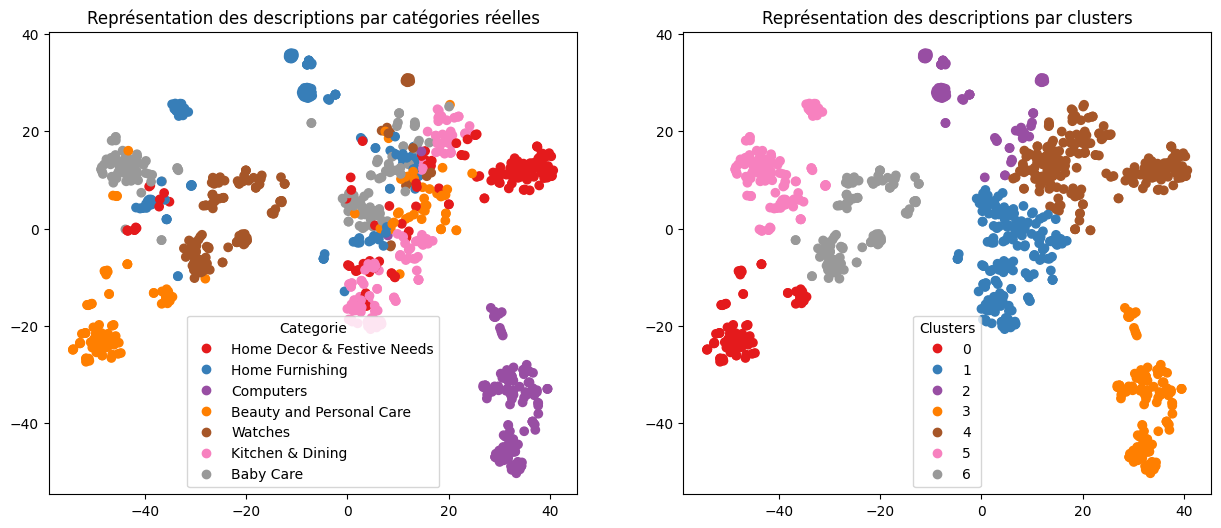

ARI :  0.4427


In [315]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

<div class="alert alert-block alert-info">
    <b> RESULTATS WORD 2 VEC : </b> 
    
- ARI :  0.4308, max_length = 200, vecteurs = 100
- ARI :  0.4319, max_length = 200, vecteurs = 200
- ARI :  0.4239, max_length = 200, vecteurs = 300
- <b> ARI :  0.4427, max_length = 300, vecteurs = 200 </b> 
    
</div>


#### 2. BERT

In [13]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.16.2
2.16.2
Num GPUs Available:  0
False


#### *** Fonctions communes ***

In [215]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    
    # Initialisation des listes pour stocker les données transformées
    input_ids = [] # Stocke les IDs des tokens pour chaque phrase.
    token_type_ids = [] # Stocke les IDs des types de tokens. Utilisé pour les tâches impliquant des paires de phrases.
    attention_mask = [] # Stocke les masques d'attention. Indique les tokens à prendre en compte (1) ou à ignorer (0).
    bert_inp_tot = [] # Stocke des tuples contenant les input_ids, token_type_ids et attention_mask pour chaque phrase.

    # Boucle sur chaque phrase dans la liste de phrases : utilisez bert_tokenizer.encode_plus pour transformer la phrase en un format compatible avec BERT
    for sent in sentences:
        # Utilisation de la méthode encode_plus du tokenizer BERT pour transformer la phrase
        bert_inp = bert_tokenizer.encode_plus(
            sent,
            add_special_tokens=True,         # Ajout des tokens spéciaux (CLS, SEP) utilisés par BERT
            max_length=max_length,           # Longueur maximale des séquences
            padding='max_length',            # Remplissage des séquences à la longueur maximale
            return_attention_mask=True,      # Retourner le masque d'attention
            return_token_type_ids=True,      # Retourner les IDs de type de token (utilisés pour les tâches avec paires de phrases)
            truncation=True,                 # Troncature des séquences plus longues que max_length
            return_tensors="tf"              # Retourner les tenseurs TensorFlow
        )

        # Ajouter les résultats aux listes respectives
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    # Conversion des listes en tableaux numpy pour une utilisation plus facile avec TensorFlow
    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    # Retourner les tableaux numpy et la liste des tuples contenant toutes les informations
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features : utilisation d'un modèle BERT pour générer des embeddings à partir de phrases données
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF'):
    batch_size = b_size  # Taille des lots pour la création des features
    batch_size_pred = b_size  # Taille des lots pour la prédiction
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)  # Initialisation du tokenizer BERT à partir du modèle spécifié
    time1 = time.time()  # Enregistrement du temps de début pour mesurer la durée du traitement

    # Boucle sur chaque lot de phrases, la boucle traite les phrases par lots de taille batch_size, idx calcule l'indice de début du lot actuel
    for step in range(len(sentences) // batch_size):
        idx = step * batch_size  # Calcul de l'indice de début du lot actuel
        # Préparation des entrées pour BERT : bert_inp_fct transforme les phrases en entrées compatibles avec BERT (fonction ci-dessus)
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx + batch_size], 
                                                                              bert_tokenizer, max_length)
        # Mode Hugging Face
        if mode == 'HF':
            # Utilise le modèle BERT pour prédire les embeddings des phrases
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state # outputs.last_hidden_state contient les états cachés de la dernière couche de BERT

        # Mode TensorFlow Hub
        if mode == 'TFhub':
            # Prépare les données pour le modèle TensorFlow Hub
            text_preprocessed = {
                "input_word_ids": input_ids, 
                "input_mask": attention_mask, 
                "input_type_ids": token_type_ids
            }
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output'] # Utilise le modèle pour obtenir les états cachés des séquences
        
        # Concaténer les états cachés du modèle BERT, si c'est le premier lot, initialisez last_hidden_states_tot, 
        # Sinon, concaténez les états cachés du lot actuel avec ceux des lots précédents
        if step == 0:
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot, last_hidden_states))
    
    # Calcul des features en prenant la moyenne des états cachés sur l'axe 1 (tokens)
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    # Calcul du temps total de traitement
    time2 = np.round(time.time() - time1, 0) # time2 mesure et affiche le temps total de traitement.
    print("temps traitement : ", time2)

    # La fonction retourne les features_bert (features moyennes pour chaque phrase) et last_hidden_states_tot (tous les états cachés concaténés)
    return features_bert, last_hidden_states_tot

#### -- BERT HuggingFace : 'bert-base-uncased' --

In [218]:
# Reprendre les descriptions d'origine pour traitement avec BERT, appliquer les minuscules et ponctuation
def clean_sentence(sentence):
    # enlever la ponctuation et les majuscules
    return "".join([i.lower() for i in sentence if i not in string.punctuation])

# Appliquer la fonction de nettoyage à chaque description
articles_text_BERT['cleaned_description'] = articles_text_BERT['description'].apply(clean_sentence)

In [220]:
print(articles_text_BERT[['description', 'cleaned_description']].head())

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                                 cleaned_description  
0  key features of elegance polyester multicolor ...  
1  specifications of sathiyas cotton bath towel 3...  
2  key features of eurospa cotton terry face towe...  
3  key features of santosh royal fashion cotton p...  
4  key features of jaipur print cotton floral kin...  


In [272]:
# Définition des Paramètres :
max_length = 30 # Longueur maximale des séquences de tokens. Les phrases plus longues seront tronquées et les plus courtes seront complétées (padded).
batch_size = 10 # Nombre d'échantillons traités ensemble pendant l'entraînement.
model_type = 'bert-base-uncased' # Spécifie le type de modèle BERT à utiliser. Ici, 'bert-base-uncased' indique l'utilisation d'un modèle BERT de taille moyenne avec des lettres minuscules uniquement.
# Test avec bert-large-uncased - bert-base-uncased

# Chargement du modèle :
model = TFAutoModel.from_pretrained(model_type) # Charge un modèle BERT pré-entraîné spécifique pour TensorFlow.
sentences = articles_text_BERT['cleaned_description'].to_list() # Données en entrée

# os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1' # Pour ne pas afficher le warning

loading configuration file config.json from cache at C:\Users\druar\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at C:\Users\druar\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a6

In [273]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')
print("Taille des features BERT:", features_bert.shape)
print("Taille des états cachés:", last_hidden_states_tot.shape)

loading configuration file config.json from cache at C:\Users\druar\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\druar\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\vocab.t

1/1 [==============================] - 0s 202ms/step
temps traitement :  34.0
Taille des features BERT: (1050, 768)
Taille des états cachés: (1050, 30, 768)


In [274]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.4605 time :  6.0


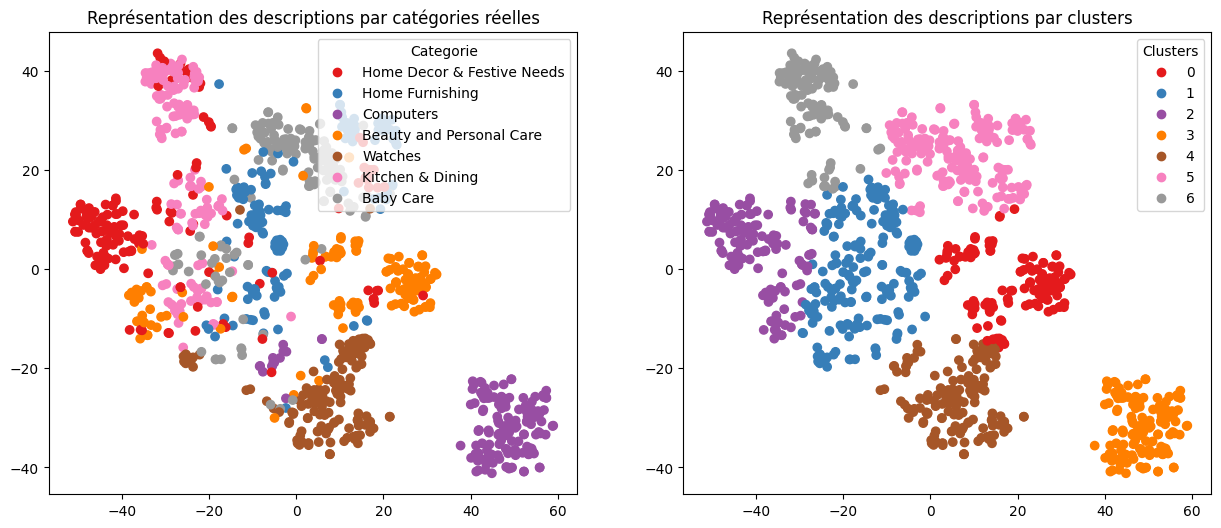

ARI :  0.4605


In [275]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

<div class="alert alert-block alert-info">
    <b> RESULTATS BERT : </b> 
    
- ARI :  0.3921, max_length = 20
- <b> ARI :  0.4605, max_length = 30 </b> 
- ARI :  0.3796, max_length = 40
- ARI :  0.3752, max_length = 50
- ARI :  0.3408, max_length = 100
- ARI :  0.2888, max_length = 300
    
</div>